# 논문 유사도 기반 군집화 (Abstract 임베딩 ver.)

**다운로드 폴더(Downloads)**의 PDF들을 대상으로, **초록(Abstract)만 발췌**해 임베딩하고 K-Means로 군집화합니다.

- 텍스트 추출: `pypdf`
- 임베딩: `sentence-transformers`
- 군집화: `scikit-learn` KMeans + 실루엣 점수
- 시각화: PCA 또는 t-SNE (2D)


### 1) 설치

In [2]:
# === HF 캐시를 현재 폴더 하위로 강제 (권한 문제 회피) ===
import os
from pathlib import Path

LOCAL_CACHE = Path.cwd() / ".hf_cache"
LOCAL_CACHE.mkdir(parents=True, exist_ok=True)

os.environ["HF_HOME"] = str(LOCAL_CACHE)
os.environ["HUGGINGFACE_HUB_CACHE"] = str(LOCAL_CACHE)
os.environ["TRANSFORMERS_CACHE"] = str(LOCAL_CACHE)
os.environ["SENTENCE_TRANSFORMERS_HOME"] = str(LOCAL_CACHE)

print("[캐시 설정 완료] HF_HOME =", os.environ["HF_HOME"])


[캐시 설정 완료] HF_HOME = /Users/hwangjeonghyun/AI-Application-Practice/.hf_cache


In [3]:
# === 폴백 포함 임베딩 로더 ===
from sentence_transformers import SentenceTransformer
import numpy as np

# 필요시 기본 모델을 바꾸고 싶으면 여기서 변경하세요.
# (권장) 다국어 품질↑: paraphrase-multilingual-mpnet-base-v2
# (경량/영문 위주): all-MiniLM-L6-v2
FALLBACK_MODELS = [
    "sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    "sentence-transformers/all-MiniLM-L6-v2",
]

# 기존 MODEL_NAME 변수를 우선 시도하고, 실패하면 위 목록 순서대로 시도
_cached_model = None
def _load_sentence_transformer(primary: str):
    global _cached_model
    if _cached_model is not None:
        return _cached_model
    candidates = [primary] + [m for m in FALLBACK_MODELS if m != primary]
    last_err = None
    for m in candidates:
        try:
            print(f"[임베딩 모델 시도] {m}")
            _cached_model = SentenceTransformer(m)
            print(f"[사용 모델] {m}")
            return _cached_model
        except Exception as e:
            print(f"  -> 실패: {type(e).__name__}: {e}")
            last_err = e
    raise RuntimeError("모든 임베딩 모델 로드에 실패했습니다.") from last_err

def embed_texts(texts, model_name: str):
    model = _load_sentence_transformer(model_name)
    return model.encode(texts, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)


/Users/hwangjeonghyun/AI-Application-Practice/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/hwangjeonghyun/AI-Application-Practice/.venv/lib/python3.13/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [4]:
# 최초 1회만 설치
! pip install -q pypdf sentence-transformers scikit-learn matplotlib tqdm


### 2) 설정

In [5]:
from pathlib import Path

# === 필수 ===
PDF_DIR = Path('/Users/hwangjeonghyun/Downloads/papers')   # ✅ 기본: 사용자의 Downloads 폴더
# 필요 시, 예: PDF_DIR = Path('/Users/내이름/Downloads/논문폴더')
PDF_DIR.mkdir(parents=True, exist_ok=True)

# === 선택 ===
K = 3                        # 고정 k
AUTO_K_RANGE = None          # 예: (2, 10) -> 실루엣 최대 k 자동 선택
MODEL_NAME = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
VIZ_METHOD = 'pca'           # '', 'pca', 'tsne'
MAX_PAGES = None             # 문서당 읽을 최대 페이지 수
RANDOM_STATE = 42

OUT_CSV = Path('cluster_results.csv')
OUT_PNG = Path('clusters_2d.png')


### 3) 유틸 함수 (PDF 추출 & Abstract 발췌)

In [6]:
import re
from typing import List, Optional
from pypdf import PdfReader

def clean_text(s: str) -> str:
    s = s.replace('\x00', ' ')
    s = re.sub(r'[ \t]+', ' ', s)
    s = re.sub(r'\n{2,}', '\n', s)
    return s.strip()

def read_pdf_text(pdf_path: Path, max_pages: Optional[int] = None) -> str:
    reader = PdfReader(str(pdf_path))
    pages = reader.pages[:max_pages] if max_pages else reader.pages
    texts = []
    for p in pages:
        try:
            t = p.extract_text() or ''
        except Exception:
            t = ''
        texts.append(t)
    return clean_text('\n'.join(texts))

def guess_title(text: str) -> str:
    if not text:
        return ''
    lines = [l.strip() for l in text.splitlines() if l.strip()]
    if not lines:
        return ''
    for l in lines[:25]:
        if len(l) > 15 and (l == l.upper() or re.search(r'[A-Z][a-z].+', l)):
            return l
    return lines[0]

def extract_abstract(full_text: str) -> str:
    """Abstract 섹션만 발췌. 실패 시 첫 페이지 상단 텍스트 일부 사용."""
    if not full_text:
        return ''
    text = full_text
    abstract_heads = [
        r'\babstract\b', r'\bsummary\b', r'\bextended abstract\b',
        r'\b초록\b', r'\b요약\b', r'\b개요\b'
    ]
    next_heads = [
        r'\bkeywords?\b', r'\bindex terms?\b',
        r'\bintroduction\b', r'\b서론\b', r'\b배경\b',
        r'\b1\.\s', r'\bⅠ\.\s', r'\bI\.\s'
    ]
    start_pos = None
    for pat in abstract_heads:
        m = re.search(pat, text, flags=re.IGNORECASE)
        if m:
            start_pos = m.start()
            break
    if start_pos is not None:
        end_pos = None
        for pat in next_heads:
            m2 = re.search(pat, text[start_pos+1:], flags=re.IGNORECASE)
            if m2:
                end_pos = start_pos + 1 + m2.start()
                break
        abstract = text[start_pos:end_pos] if end_pos else text[start_pos:]
        abstract = abstract.strip()
        if len(abstract) >= 80:
            return abstract
    lines = text.splitlines()
    first_chunk = '\n'.join(lines[:120])
    if len(first_chunk) < 200:
        first_chunk = text[:2000]
    return first_chunk.strip()


### 4) 임베딩 & 클러스터링 함수

In [7]:
import numpy as np
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def embed_texts(texts: List[str], model_name: str) -> np.ndarray:
    model = SentenceTransformer(model_name)
    emb = model.encode(texts, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)
    return emb

def run_kmeans(emb: np.ndarray, k: int, random_state: int = 42):
    km = KMeans(n_clusters=k, n_init='auto', random_state=random_state)
    labels = km.fit_predict(emb)
    sil = -1.0
    if k > 1:
        try:
            sil = silhouette_score(emb, labels, metric='cosine')
        except Exception:
            pass
    return km, labels, sil

def auto_select_k(emb: np.ndarray, k_min: int, k_max: int, random_state: int = 42):
    scores = {}
    best_k, best_s = None, -2.0
    for k in range(k_min, k_max+1):
        _, labels, sil = run_kmeans(emb, k, random_state=random_state)
        scores[k] = sil
        if sil > best_s:
            best_s, best_k = sil, k
    return best_k, best_s, scores

def reduce_2d(emb: np.ndarray, method: str = 'pca', random_state: int = 42) -> np.ndarray:
    m = method.lower()
    if m == 'pca':
        return PCA(n_components=2, random_state=random_state).fit_transform(emb)
    elif m == 'tsne':
        return TSNE(n_components=2, random_state=random_state, init='pca', perplexity=30, learning_rate='auto').fit_transform(emb)
    else:
        raise ValueError("method must be '', 'pca', or 'tsne'")


### 5) 실행: Downloads의 PDF -> 초록 임베딩 -> kmeans -> 결과 출력/저장 

[정보] PDF 개수: 10
[정보] 임베딩 모델: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
[단계] PDF 텍스트 추출 및 Abstract 발췌 중...
[단계] 임베딩 생성(SBERT, Abstract 전용)...


Batches: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[설정] 고정 k=3
[단계] K-Means 클러스터링...
[지표] 실루엣 점수(코사인): 0.1921

[클러스터 0] 문서 수: 3
  - (01) 바이오헬스산업에있어블록체인기술을활용한빅데이터의수집․활용및지식재산권보호를위한법적연구*손정은**1) ≪차례≫Ⅰ.서론Ⅱ.바이오헬스산업과빅데이터의법적특성Ⅲ.블록체인기술의바이오빅데이터활용가능성Ⅳ.국가통합바이오빅데이터구축사업의법적․윤리적쟁점과블록체인연계방안Ⅴ.비교법적검토Ⅵ.제도개선을위한입법적․정책적방안Ⅶ.결론  |  파일: 바이오헬스산업에 있어 블록체인기술을 활용한 빅데이터의 수집 · 활용 및 지식재산권 보호를 .pdf
  - (02) 한국컴퓨터정보학회 하계학술대회 논문집 제33권 제2호 (2025. 7)  |  파일: 블록체인 기반 다변량 데이터의 효과적 관리를 위한 PCA 적용 연구.pdf
  - (03) 무역통상학회지 제25권 제04호 2025. 08 121  |  파일: 블록체인기술과 공급사슬 성과에 관한 연구 지속가능성을 중심으로.pdf
----------------------------------------------------------------------
[클러스터 1] 문서 수: 4
  - (01) 진현석1 ･ 정아람2 ･ 오철3*  |  파일: 고속도로 자율주행 도입에 따른 잠재적 교통안전 개선 효과 분석에 관한 연구.pdf
  - (02) 자율주행 기술의 문제 식별 및 해결을 위한  |  파일: 자율주행 기술의 문제 식별 및 해결을 위한 이종 산업 융합 가능성 탐색 방법론.pdf
  - (03) Journal of The Institute of Electronics and Information Engineers Vol.62, NO.8, August 2025 https://doi.org/10.5573/ieie.2025.62.8.126  |  파일: 자율주행 데이터 구축 현황.pdf
  - (04) 철도 열차 제어의 도로 자율주행 적용 방안 및 선행 차량 추종 모델에 대한 효율성 개선 효  |  파일:

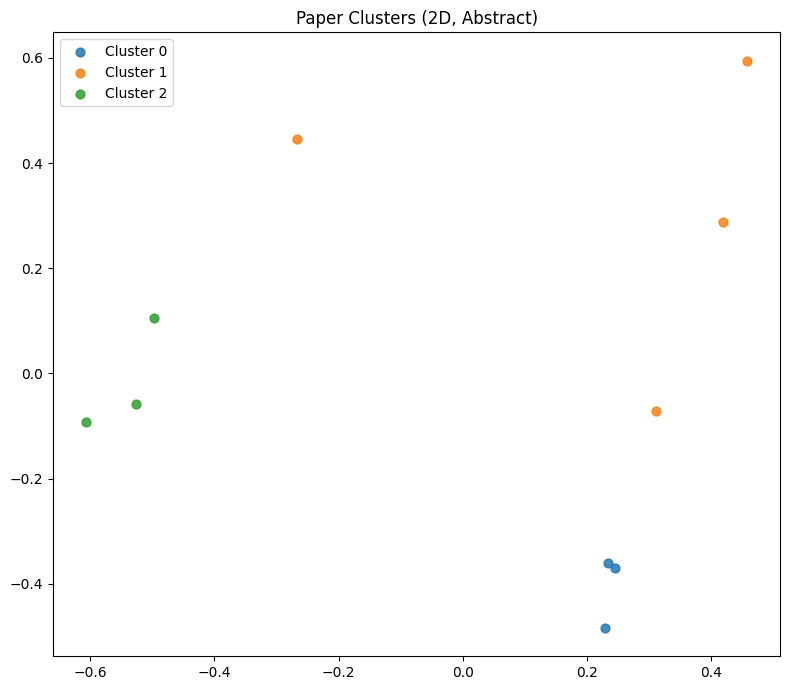

[저장] 시각화: /Users/hwangjeonghyun/AI-Application-Practice/clusters_2d.png


In [9]:
import csv

pdf_files = sorted(PDF_DIR.glob('*.pdf'))
if not pdf_files:
    raise FileNotFoundError(f'PDF 파일이 없습니다: {PDF_DIR.resolve()}')

print(f'[정보] PDF 개수: {len(pdf_files)}')
print(f'[정보] 임베딩 모델: {MODEL_NAME}')

# 1) PDF 텍스트 추출 & Abstract 발췌
raw_texts, abstracts, titles = [], [], []
print('[단계] PDF 텍스트 추출 및 Abstract 발췌 중...')
for p in pdf_files:
    txt = read_pdf_text(p, max_pages=MAX_PAGES)
    abs_txt = extract_abstract(txt)
    raw_texts.append(txt)
    abstracts.append(abs_txt if abs_txt else '')
    titles.append(guess_title(txt) or p.stem)

# 2) 임베딩 (Abstract만)
print('[단계] 임베딩 생성(SBERT, Abstract 전용)...')
emb = embed_texts(abstracts, model_name=MODEL_NAME)

# 3) k 선택
if AUTO_K_RANGE is not None and isinstance(AUTO_K_RANGE, tuple):
    k_min, k_max = AUTO_K_RANGE
    print(f'[단계] k 자동 탐색: {k_min}~{k_max}')
    best_k, best_s, scores = auto_select_k(emb, k_min, k_max, random_state=RANDOM_STATE)
    print('[결과] k별 실루엣 점수(코사인):')
    for k in sorted(scores.keys()):
        print(f'  - k={k:2d}: {scores[k]:.4f}')
    K_effective = best_k
    print(f'[선택] 최적 k={K_effective} (실루엣={best_s:.4f})')
else:
    K_effective = K
    print(f'[설정] 고정 k={K_effective}')

# 4) 클러스터링
print('[단계] K-Means 클러스터링...')
km, labels, sil = run_kmeans(emb, k=K_effective, random_state=RANDOM_STATE)
if K_effective > 1:
    print(f'[지표] 실루엣 점수(코사인): {sil:.4f}')

# 5) 결과 출력
clusters = {}
for i, lab in enumerate(labels):
    clusters.setdefault(lab, []).append(i)

print('\n' + '='*70)
for lab in sorted(clusters.keys()):
    idxs = clusters[lab]
    print(f'[클러스터 {lab}] 문서 수: {len(idxs)}')
    for j, i in enumerate(idxs, start=1):
        fn = pdf_files[i].name
        title = titles[i]
        print(f'  - ({j:02d}) {title}  |  파일: {fn}')
    print('-'*70)

# 6) CSV 저장
with open(OUT_CSV, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['filename', 'title', 'cluster'])
    for i, p in enumerate(pdf_files):
        writer.writerow([p.name, titles[i].replace(',', ' '), labels[i]])
print(f'\n[저장] CSV: {OUT_CSV.resolve()}')

# 7) (옵션) 2D 시각화
if VIZ_METHOD in ('pca', 'tsne'):
    print(f'[단계] 2D 시각화({VIZ_METHOD}) 생성...')
    coords2d = reduce_2d(emb, method=VIZ_METHOD, random_state=RANDOM_STATE)
    plt.figure(figsize=(8,7))
    for k in sorted(clusters.keys()):
        idx = np.where(labels == k)[0]
        plt.scatter(coords2d[idx,0], coords2d[idx,1], s=40, alpha=0.85, label=f'Cluster {k}')
    plt.title('Paper Clusters (2D, Abstract)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUT_PNG, dpi=200)
    plt.show()
    print(f'[저장] 시각화: {OUT_PNG.resolve()}')
else:
    print("[정보] 시각화 생략 (VIZ_METHOD='').")
